In [ ]:
import json
from string import punctuation as punc
from glob import glob

import nltk
from PIL import Image
import os
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
import random
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

In [ ]:
# load dataset
!gdown --id 1D7HvzD_NT70Y0WjHO1xkP4zGAt3YfHCK

Downloading...
From: https://drive.google.com/uc?id=1D7HvzD_NT70Y0WjHO1xkP4zGAt3YfHCK
To: /content/images.zip
6.76GB [02:26, 46.0MB/s]


In [ ]:
# load captions
!gdown --id 1o2bmBCxZ1aSrTWnbe42XitiAM2sHJKrX

Downloading...
From: https://drive.google.com/uc?id=1o2bmBCxZ1aSrTWnbe42XitiAM2sHJKrX
To: /content/captions.json
2.65MB [00:00, 12.5MB/s]


In [ ]:
# load vector file with zip format
!gdown --id 1in1MbQXieuvytsqIP9Q8qFgnTSZEHMue

Downloading...
From: https://drive.google.com/uc?id=1in1MbQXieuvytsqIP9Q8qFgnTSZEHMue
To: /content/bn_glove.100d.zip
51.2MB [00:01, 26.7MB/s]


In [ ]:
# unzip it
!7z x "/content/bn_glove.100d.zip"


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 51174725 bytes (49 MiB)

Extracting archive: /content/bn_glove.100d.zip
--
Path = /content/bn_glove.100d.zip
Type = zip
Physical Size = 51174725

  0%     16% - bn_glove.100d.txt                         34% - bn_glove.100d.txt                         52% - bn_glove.100d.txt                         70% - bn_glove.100d.txt                         85% - bn_glove.100d.txt                        Everything is Ok

Size:       130623492
Com

In [ ]:
# unzip dataset
!7z x "/content/images.zip"


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 6758950318 bytes (6446 MiB)

Extracting archive: /content/images.zip
  2% 256 Open               8% 768 Open              13% 1280 Open               16% 1536 Open               19% 1792 Open               25% 2304 Open               30% 2816 Open               36% 3328 Open               41% 3840 Open               47% 4352 Open               53% 4864 Open              
ERRORS:

In [ ]:
#Reading JSON file to extract the captions
# punctuation remover
# chr(2404) : bengali full-stop unicode
punc_table = str.maketrans('', '', punc+chr(2404))

with open("/content/captions.json", mode='rb') as f:
    caption_data = json.load(f)

caps = {}
for cap in caption_data:
    tmp = []
    for sentence in cap['caption']:
        # Removing spaces from front and back
        tstr = sentence.strip()
        # Removing extra spaces from middle
        tstr = ' '.join(tstr.split())
        tstr = tstr.translate(punc_table)

        tmp.append('startseq ' + tstr + ' endseq')
    
    caps[cap['filename'].split('.')[0]] = tmp
    

In [ ]:
#An example of the RAW JSON data
for a in caption_data[:2]:
    print(a)

{'filename': '1.png', 'caption': ['তিন জন মেয়ে মানুষ আছে। এক জন দাড়িয়ে আছে আর দুই জন বসে আছে।', 'একটি হলুদ জামা পায়জামা পরা মহিলা দাড়িয়ে হাতে একটি বেত নিয়ে পিটানোর ভাব দেখাচ্ছে আর ছোট একটি মেয়ে পিছনে ব্যাগ নিয়ে বসে কাঁদছে। ']}
{'filename': '2.png', 'caption': ['অনেক মেয়ে মানুষ বসে আছে।', 'একটি নীল জামা পরা মহিলা একটি নীল ল্যাপটপ এর দিকে তাকিয়ে আছে এবং পিছনে  তার দিকে বসে শারি পরে তাকিয়ে আছে অনেকগুলো মহিলা। ']}


In [ ]:
for a in caption_data[:4]:
    print(a)

{'filename': '1.png', 'caption': ['তিন জন মেয়ে মানুষ আছে। এক জন দাড়িয়ে আছে আর দুই জন বসে আছে।', 'একটি হলুদ জামা পায়জামা পরা মহিলা দাড়িয়ে হাতে একটি বেত নিয়ে পিটানোর ভাব দেখাচ্ছে আর ছোট একটি মেয়ে পিছনে ব্যাগ নিয়ে বসে কাঁদছে। ']}
{'filename': '2.png', 'caption': ['অনেক মেয়ে মানুষ বসে আছে।', 'একটি নীল জামা পরা মহিলা একটি নীল ল্যাপটপ এর দিকে তাকিয়ে আছে এবং পিছনে  তার দিকে বসে শারি পরে তাকিয়ে আছে অনেকগুলো মহিলা। ']}
{'filename': '3.png', 'caption': ['অনেক মানুষ একসাথে বসে কাজ করছে।', '২ টি  ছোট ছেলে একজন শার্ট প্যান্ট  দাড়িয়ে চেয়ে আছে আরেকজন বসে গার্মেন্টস এ কাজ করছে নীল  শার্ট পরে তাদের পিছনে অনেকগুলো মহিলা বসে দাড়িয়ে কাজ করছে।  ']}
{'filename': '4.png', 'caption': ['ছয় জন মানুষ দাড়িয়ে আছে।', '৬ জন মানুষ এলোমেলো দাড়িয়ে আছে, তাদের মাঝে ২ জন ছেলে ৪ জন পুরুষ,  তাদের একজন লুঙ্গী পরে দাড়িয়ে আছে। ']}


In [ ]:
print(caption_data[4])

{'filename': '5.png', 'caption': ['এক জন মেয়ে মানুষ মাথায় ঘোমটা দিয়ে কাজ করছে। মাটিতে বিভিন্ন রঙের মসলা আছে।', 'একটি মহিলা হালকা পানির উপরে দাড়িয়ে আছে শারি পরে, মহিলার মুখ ডানদিকে ঘুরানো, পানির রং হলুদ দেখাচ্ছে। ']}


In [ ]:
print(caption_data[3])

{'filename': '4.png', 'caption': ['ছয় জন মানুষ দাড়িয়ে আছে।', '৬ জন মানুষ এলোমেলো দাড়িয়ে আছে, তাদের মাঝে ২ জন ছেলে ৪ জন পুরুষ,  তাদের একজন লুঙ্গী পরে দাড়িয়ে আছে। ']}


In [ ]:
#What it looks like after being converted
print(caps['1'])
print(caps['2'])

['startseq তিন জন মেয়ে মানুষ আছে এক জন দাড়িয়ে আছে আর দুই জন বসে আছে endseq', 'startseq একটি হলুদ জামা পায়জামা পরা মহিলা দাড়িয়ে হাতে একটি বেত নিয়ে পিটানোর ভাব দেখাচ্ছে আর ছোট একটি মেয়ে পিছনে ব্যাগ নিয়ে বসে কাঁদছে endseq']
['startseq অনেক মেয়ে মানুষ বসে আছে endseq', 'startseq একটি নীল জামা পরা মহিলা একটি নীল ল্যাপটপ এর দিকে তাকিয়ে আছে এবং পিছনে তার দিকে বসে শারি পরে তাকিয়ে আছে অনেকগুলো মহিলা endseq']


In [ ]:
#Fetching image paths
image_dirs = glob("/content/images/**")
print(len(image_dirs), "images found")

9154 images found


In [ ]:
#Example of three image paths
print(image_dirs[:3])

['/content/images/9154.png', '/content/images/7687.png', '/content/images/5008.png']


In [ ]:
imgs = {}

# Remove the [:5]
for img_dir in tqdm(image_dirs):
    img = Image.open(img_dir).resize((299, 299))
    img = np.array(img)

    img_idx = img_dir.split('/')[-1]
    img_idx = img_idx.split('.')[0]
    imgs[img_idx] = img

In [ ]:
#caps : caption dictionary
word_count = {}

for sentences in caps.values():
    for sentence in sentences:
        for word in sentence.split():
            if word not in word_count:
                word_count[word] = 0
            word_count[word] += 1

In [ ]:
print(len(word_count), 'unique words')

5189 unique words


In [ ]:
vocab = set(word for word, cnt in word_count.items() if cnt >= 2)
print(len(vocab), 'unique words after filter')

2814 unique words after filter


In [ ]:
print(vocab)

{'অনেকের', 'তলায়', 'হাসের', 'পাতিলের', 'সিলেট', 'গাড়িতে', 'ড্রেস', 'কুয়াশাছন্ন', 'রেললাইনের', 'যার', 'হরিণের', 'উপুড়', 'পুলিশ', 'ড্রয়িং', 'মসজিদের', 'ঝাড়ের', 'মাদ্রাসায়', 'পাশে', 'হকার', 'এখানে', 'কাপে', 'ভিড়ানো', 'চলাফেরা', 'টেবিলে', 'ভাত', 'ঘোড়ার', 'কাঁদার', 'কচুরিপনায়', 'গুড়ি', 'শিখাচ্ছে', 'বাচ্চা', 'সমুদ্রের', 'চুড়ি', 'গ্যালারীতে', 'লোকটি', 'বাঁশি', 'নৌকাটি', 'ছোট', 'প্লাটফর্ম', 'কম্পিউটার', 'কুয়াশার', 'নাস্তা', 'ঝালমুড়ির', 'কেটে', 'কলস', 'সাদাহলুদ', 'মাইকিং', 'বুজা', 'পুকুর', 'কাপড়ের', 'সূর্যাস্তের', 'বাসা', 'ঘাসফুল', 'মাইকে', 'ঢেকে', 'তরমুজ', 'রিক্সায়', 'দাড়ি', 'পয়সা', 'ক্রেস্ট', 'খুঁটি', 'লোহায়', 'চাষ', 'নালার', 'ডাস্টবিন', 'পাড়র্কে', 'ভর', 'বিছিয়ে', 'করানো', 'মাদ্রাসার', 'গুলাপি', 'হারমনি', 'আরো', 'সাহায্য', 'কচুরি', 'কাগজে', 'পাট', 'দুরের', 'ফসল', 'চোখে', 'নিচ্ছে', 'বায়োস্কপ', 'ফুচকা', 'মারামারি', 'ওপর', 'তালি', 'উড়াচ্ছে', 'পড়ছে', 'আড়ালে', 'আইনা', 'সান', 'বাচ্চাটাকে', 'যেন', 'হাসছেন', 'চেহারা', 'ভবনে', 'গাইছে', 'দেখতে', 'তারা', 'ব্যাঙ', 'বিজয়', 'তুলার', 'ফিরানো', 'অপরকে', 'সব

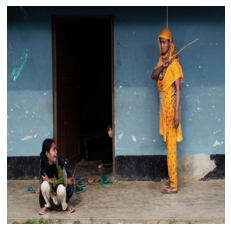

Actual Caption: startseq তিন জন মেয়ে মানুষ আছে এক জন দাড়িয়ে আছে আর দুই জন বসে আছে endseq
Filtered Caption: startseq তিন জন মেয়ে মানুষ আছে এক জন দাড়িয়ে আছে আর দুই জন বসে আছে endseq


In [ ]:
idx = '1'
plt.imshow(imgs[idx])
plt.axis(False)
plt.show()

id = 0

print('Actual Caption:', caps[idx][id])
cap = [x for x in (caps[idx][id]).split() if x in vocab]
print('Filtered Caption:', ' '.join(cap))

In [ ]:
new_caps = {}
max_len = 0

for key, values in caps.items():
    tmp = []
    
    for value in values:
        fvalue = [x for x in value.split() if x in vocab]
        if len(fvalue) >= 2:
            tmp.append(' '.join(fvalue))
            max_len = max(max_len, len(fvalue))
    
    if len(tmp) > 0:
        new_caps[key] = tmp

print(max_len)

39


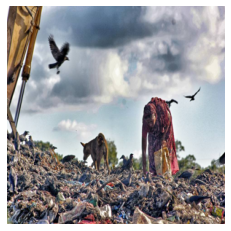

Captions:
startseq একজন নারী আছে endseq
startseq ময়লার উপরে ময়লা বাছায় করছে একজন মহিলা এবং কিছু কাক উড়ছে এবং ১ টি কুকুর দাড়িয়ে আছে endseq


In [ ]:
idx = '5549'
plt.imshow(imgs[idx])
plt.axis(False)
plt.show()
print('Captions:')
for cap in new_caps[idx]:
    print(cap)

In [ ]:
word_to_id = {}
id_to_word = {}

id = 1
for word in vocab:
    word_to_id[word] = id
    id_to_word[id] = word
    id += 1

In [ ]:
vocab_size = len(vocab) + 1
embedding_dim = 100
max_len = 39

In [ ]:
# Reading Glove embedding

glove_path = "/content/bn_glove.100d.txt"
embedding_matrix = np.zeros((vocab_size, embedding_dim))
embd_cnt = 0

with open(glove_path, mode='r', encoding="utf-8") as f:
    for line in tqdm(f.readlines()):
        chunks = line.split()
        word, embedding = chunks[0], chunks[1:]

        if word in vocab:
            id = word_to_id.get(word)
            embedding_matrix[id] = embedding
            embd_cnt += 1

print(embd_cnt, 'embeddings found')



1999 embeddings found


In [ ]:
model = tf.keras.applications.Xception(input_shape=(299, 299, 3),
                                       include_top=True)

model = tf.keras.Model(model.input, model.layers[-2].output)
#model.summary()

91889664/91884032 [==============================] - 1s 0us/step


In [ ]:
cimgs = {}

for key, img in tqdm(imgs.items()):
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.xception.preprocess_input(img)
    tmp = model(img)
    cimgs[key] = np.reshape(tmp, (2048))
    #print(tmp.shape)

In [ ]:
# Saving processed data for future use
import pickle
save_path = "/content/executed"

def save_variables(vars, base_dir):
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)

    for var in vars:
        with open(os.path.join(base_dir, (var+'.pkl')), 'wb') as f:
            pickle.dump(eval(var), f)


def load_variables(vars, base_dir):
    if not os.path.exists(base_dir):
        print('Invalid path')
        return

    rets = {}
    for var in vars:
        with open(os.path.join(base_dir, (var+'.pkl')), 'rb') as f:
            rets[var] = pickle.load(f)
    return list(rets.values())

In [ ]:
save_variables(['word_to_id', 
                'id_to_word', 
                'cimgs', 
                'embedding_matrix',
                'new_caps'],
               save_path)

In [ ]:
word_to_id, id_to_word, cimgs, embedding_matrix, \
new_caps = load_variables(['word_to_id', 
                           'id_to_word', 
                           'cimgs', 
                           'embedding_matrix',
                           'new_caps'],
                          save_path)

vocab_size, embedding_dim = embedding_matrix.shape
max_len = 39

In [ ]:
def caption_model(input_shape, embedding_dim, vocab_size,
                  embedding_matrix, trainable=True):
    # Image embedding input
    input1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(input1)
    fe2 = Dense(256, activation='relu')(fe1)
    
    # Word embedding input
    input2 = Input(shape=(max_len,))
    se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(input2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    
    # Merging the inputs
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    cmodel = tf.keras.Model(inputs=[input1, input2], outputs=outputs)
    
    cmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

    cmodel.layers[2].set_weights([embedding_matrix])
    cmodel.layers[2].trainable = trainable

    return cmodel
    

In [ ]:
cmodel = caption_model((2048,), embedding_dim, vocab_size,
                       embedding_matrix)

In [ ]:
class dataGenerator(tf.keras.utils.Sequence):
    """ Recieves X and y 
        Performes pairwise matching with a batch size 
        both pairs are generated from the input X and y
    """
    def __init__(self, img_emb, captions, word_to_id, batch_size=12):
        self.imgs        = img_emb 
        self.caps        = captions
        self.batch_size  = batch_size
        self.word_to_id  = word_to_id
        self.keys        = list(self.imgs.keys())
        self.total       = len(self.keys)
        self.on_epoch_end()

    def __len__(self):
        """ Denotes the number of batches per epoch """
        return int(self.total // self.batch_size)

    def __getitem__(self, index):
        """ Generate one batch of data """
        batch_keys = self.keys[index*self.batch_size:(index+1)*self.batch_size]
        X1, X2, y = [], [], []
        
        #print(len(batch_keys))

        for key in batch_keys:
            id = random.randint(0, len(self.caps[key])-1)
            cap_id = [word_to_id[word] for word in self.caps[key][id].split()]

            for i in range(1, len(cap_id)):
                inp_seq, out_seq = cap_id[:i], cap_id[i]
                
                inp_seq = pad_sequences([inp_seq], maxlen=max_len)[0]
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                X1.append(self.imgs[key])
                X2.append(inp_seq)
                y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        choices = random.sample(range(0, X1.shape[0]), self.batch_size*4)

        return [X1[choices], X2[choices]], y[choices]
        

    def on_epoch_end(self):
        """ Updates indexes after each epoch """
        np.random.shuffle(self.keys)

In [ ]:
train_index, test_index = train_test_split(list(cimgs.keys()), 
                                           test_size=0.80,
                                           random_state=42)

In [ ]:
train_cimgs = {key:cimgs.get(key) for key in train_index}
test_cimgs  = {key:cimgs.get(key) for key in test_index}

In [ ]:
batch_size = 256

train_gen = dataGenerator(train_cimgs, new_caps, word_to_id, 
                          batch_size=batch_size//4)
test_gen  = dataGenerator(test_cimgs, new_caps, word_to_id, 
                          batch_size=batch_size//4)

[a, b], c = train_gen[0]
print(a.shape, c.shape)


(256, 2048) (256, 2815)


In [ ]:
callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                             patience=10, 
                                             verbose=1, 
                                             restore_best_weights=True),
             
            tf.keras.callbacks.ModelCheckpoint(os.path.join(save_path, 'model'), 
                                               monitor="val_loss",
                                               save_weights_only=False,
                                               mode='min',
                                               save_best_only=True),
        ]

In [ ]:
his = cmodel.fit(train_gen, validation_data=test_gen,
                 epochs=100, callbacks=callbacks)

Epoch 1/100
28/28 [==============================] - 9s 315ms/step - loss: 2.5367 - acc: 0.4381 - val_loss: 2.6491 - val_acc: 0.4372


INFO:tensorflow:Assets written to: /content/executed/model/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: /content/executed/model/assets


Epoch 2/100
28/28 [==============================] - 8s 305ms/step - loss: 2.4789 - acc: 0.4422 - val_loss: 2.6460 - val_acc: 0.4416


INFO:tensorflow:Assets written to: /content/executed/model/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
INFO:tensorflow:Assets written to: /content/executed/model/assets


Epoch 3/100
28/28 [==============================] - 9s 310ms/step - loss: 2.4952 - acc: 0.4348 - val_loss: 2.6471 - val_acc: 0.4373
Epoch 4/100
28/28 [==============================] - 8s 305ms/step - loss: 2.4242 - acc: 0.4456 - val_loss: 2.6700 - val_acc: 0.4370
Epoch 5/100
28/28 [==============================] - 8s 307ms/step - loss: 2.3993 - acc: 0.4466 - val_loss: 2.6484 - val_acc: 0.4416
Epoch 6/100
28/28 [==============================] - 8s 308ms/step - loss: 2.3093 - acc: 0.4609 - val_loss: 2.6655 - val_acc: 0.4396
Epoch 7/100
28/28 [==============================] - 8s 305ms/step - loss: 2.3326 - acc: 0.4551 - val_loss: 2.7092 - val_acc: 0.4316
Epoch 8/100
28/28 [==============================] - 8s 306ms/step - loss: 2.2861 - acc: 0.4644 - val_loss: 2.6683 - val_acc: 0.4371
Epoch 9/100
28/28 [==============================] - 8s 306ms/step - loss: 2.2171 - acc: 0.4831 - val_loss: 2.7038 - val_acc: 0.4324
Epoch 10/100
28/28 [==============================] - 9s 311ms/step -

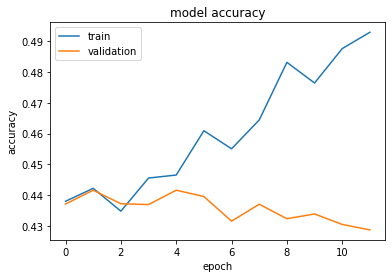

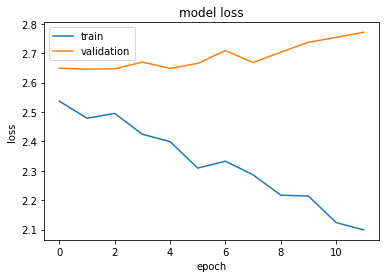

In [ ]:
#print(history.history.keys())
#  "Accuracy"
plt.plot(his.history['acc'])
plt.plot(his.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid
plt.show()
# "Loss"
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
cmodel = tf.keras.models.load_model("/content/executed/model")

In [ ]:
def greedySearch(photo_embedding):
    in_text = 'startseq'
    photo_embedding = np.expand_dims(photo_embedding, axis=0)

    for i in range(max_len):
        sequence = [word_to_id[w] for w in in_text.split() if w in word_to_id]
        sequence = pad_sequences([sequence], maxlen=max_len)

        yhat = cmodel.predict([photo_embedding, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = id_to_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

Predicted
 একজন পুরুষ ও একজন পুরুষ পাশাপাশি দাড়িয়ে আছে
Ans
রাস্তার উপর তিনজন পুরুষ দাড়িয়ে আছে
৪ জন ছেলে দাড়িয়ে কথা বলছে যার মাঝে একজন হাতে একটি কাগজ এবং ৩ জন ব্যাগ নিয়ে দাড়িয়ে আছে
0.5629649335874473


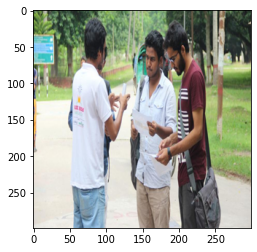

In [ ]:
imgid = list(test_cimgs.keys())[21]

plt.imshow(imgs[imgid])
plt.grid(False)

pred = greedySearch(test_cimgs[imgid])
ans = []

print("Predicted\n", pred)
print("Ans")
for c in new_caps[imgid]:
    cc = " ".join(c.split()[1:-1])
    ans.append(cc)
    print(cc)

BLEUscore = nltk.translate.bleu_score.sentence_bleu(ans, pred)
print(BLEUscore)

In [ ]:
scores = []

for imgid in tqdm(test_cimgs.keys()):
    pred = greedySearch(test_cimgs[imgid])
    ans = []

    for c in new_caps[imgid]:
        cc = " ".join(c.split()[1:-1])
        ans.append(cc)
        #print(cc)

    BLEUscore = nltk.translate.bleu_score.sentence_bleu(ans, pred)
    scores.append(BLEUscore)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
print(sum(scores)/len(scores))

0.4432204999316667


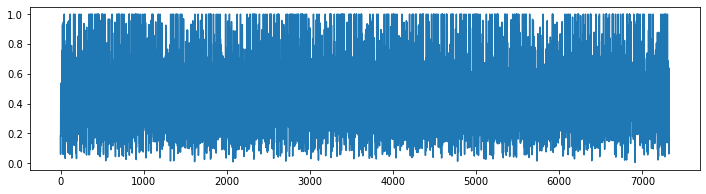

In [ ]:
plt.figure(figsize=(12, 3))
plt.plot(np.arange(len(scores)), scores)